# Detect Spiral Tips from Canvas

Timothy Tyree

10.22.2019

In [2]:
#Day1
#it looks like both skimage and cv2 are good for image processing and basic machine learning.
#opencv (cv2) is better for computer vision and speed
#skimage is easier to use and better documented
#let's use skimage for now

#DONE: import a snapshot sample from afib.ucsd.edu manually with 
#DONE: detect some activation/deactivation curves
#DONE: get spline fit of ^those curves
#DONE: calculate intersection.  Record.
#DONEish: compare to spiral tip
#TODO: make curve selection interactive; pyqt5 could be a long term interface for this
#     select rbga color and highlight that colorband for interactive curve selection

#Day2 (do this later)
#TODO: add options to output rbga channels from website
#TODO: use rgba channels to calculate my 'activation/deactivation' curves
#TODO: get spline fit of ^those curves
#TODO: calculate intersection. Record and compare.

#Day3
#skipTODO: repeat ^that for a few more snapshots.
#skipTODO: compare tip positions

#TODO: make a data pipeline
#TODO: call a 'helloworld.py' script from env.render or something
#TODO: make a callable script 'find_tips.py' pre-calibrated for default display
#TODO: figure out if I can easily efficiently pass canvas information from js to 'find_tips.py'
#TODO: ^if so, get a sample out of FastAFSimulator2D with the best spiral tips
#TODO: see if ^that sample has the robustness result, $W_{\pm1}=0$
#TODO: update and communicate, yo

#Day4 (do this later)
#TODO: make curve selection interactive so different cmaps can be used
#TODO: (Dicty. D.) batch 051719Pos4 features with tf.data for RNN or LSTM!


In [1580]:
import numpy as np
import pandas as pd
import skimage as sk
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import measure
import time 
from scipy import stats

# #for corner detection, yikes
# from skimage import data
# from skimage.feature import corner_harris, corner_subpix, corner_peaks
# from skimage.transform import warp, AffineTransform
# from skimage.draw import ellipse

from scipy.interpolate import BSpline
from scipy.optimize import fsolve

# Import sample from FastAFSimulator2D

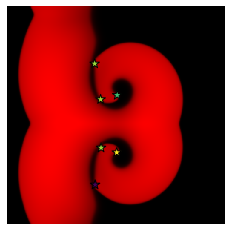

In [1585]:
# import a previous snapshot to tell if a given cell is increasing or decreasing.
canvas_dir = '../data/redsample000792.png'
canvas_old_dir = '../data/redsample000788.png'
pos_dir = '../data/redsample.csv'

#import a snapshot sample fromafib.ucsd.edu manually
# canvas_dir = '../data/canvas_sample.png'
# pos_dir = '../data/positions_sample_last_entry.csv'
img = sk.io.imread(canvas_dir, as_gray=False)
img_old = sk.io.imread(canvas_old_dir, as_gray=False)
df  = pd.read_csv(pos_dir)
df = df.iloc[-1]
pts = np.array(df.name[5:]); del df
pts = pts[pts>0]
pts = np.reshape(pts, (6,4))

#view spiral tip positions and flip y axis
x_values = pts[:,2]*512
y_values = (1-pts[:,3])*512
c_values = -pts[:,1] #color by I_fi
plt.imshow(img, cmap='gray')
plt.scatter(x=x_values, y=y_values, c=c_values, s=100, marker='*', edgecolor='black',)
plt.axis('off')
plt.show()
# plt.savefig('../fig/pts_sampled_from_canvas.png', dpi=300)
pts_sampled = np.vstack([x_values, y_values]).T; del pts

In [1586]:
#import known colorbar/voltage mask
cmap_dir = '../data/colormaps/mat/red.png'
cmap = sk.io.imread(cmap_dir, as_gray=False)
width= cmap.shape[1]
assert np.array_equal(cmap[1,:,0],np.arange(256))
# f = lambda y,x: np.array_equal(y,x)

In [1587]:
# [Deprecated]
#define scale from colors to Vmem with cmap
# define np.vectorize(lambda ...) to map rgb data to 
# cmap[0]-cmap[1]#the first and second dictionaries are for some rbg periodic b.c.'s'
# search cmap[0] and then cmap[1] for (rounded?) color matches.
# if one is found assign scalar value for output
# def invcmp(rgb):
#     """[Deprecated] slowly map the 'rainbowHotSpring' cmap to it's scalar value between 0 and 1"""
#     m = np.argwhere([f(rgb,x) for x in cmap[1]])
#     if m.size>0:
#         return m.mean()
#         #         return (m[:,1].mean()/width)
#     else:
#         m = np.argwhere([f(rgb,x) for x in cmap[0]])
#         if m.size>0:
#             return m.mean()
#         else:
#             return np.nan
# invcmp  = np.vectorize(invcmp, otypes=[np.float], signature="(3)->()")
# image_old_invcmp = image_old
# # # image_invcmp = image
# image = np.array([img[i,j,:3].sum()/3/256 for i in range(512) for j in range(512)]).reshape(512,512)
# image_old = np.array([img_old[i,j,:3].sum()/3/256 for i in range(512) for j in range(512)]).reshape(512,512)

In [1588]:
# map an rgb from '/mat/red' cmap to it's scalar value between 0 and 1 by just selecting the red channel"""
image = img[:,:,0]/255
image_old = img_old[:,:,0]/255

In [1589]:
#DONE: reshape img into a 1D array of rbg vectors
#DONE: unfold the rgb image and verify you get the original image
#DONE: map each value in that 1D array to it's scalar value
#DONE: unfold those scalar values back into a scalar image
# img[:,:,:3].reshape(img.shape[0]*2,3)
# # img[:,:,:3]
# print(invcmp(img[1,0:3,:3]))
# print(invcmp(img[1,0,:3]))
# print(invcmp(img[1,1,:3]))
# print(invcmp(img[1,2,:3]))
# # [invcmp(x) for x in img[:,:,:3]]

# np.argwhere([f(img[1,1,:3],x) for x in cmap[1]])
# [np.equal(img[1,1,:3],x) for x in cmap]
# np.argwhere(
#     , where=[True,True,True])

# start = time.time()
# # #this can be much faster but I've wasted too much time trying to make this efficient
# imglin = img.reshape(512**2,4)
# out = np.zeros(512**2)
# for i in np.arange(0,512**2,1):
#     out[i] = invcmp(imglin[i,:3])
# #     out.append(invcmp(imglin[i,:3]))
# end = time.time()
# print(end-start)
# image = out.reshape(512,512)/256

# plt.imshow(image, cmap=plt.cm.gray)

So this is stupid. For some reason "Chaos Labs" made their signature color map not have a unique rgb value for each scalar value 0:1.  The simplest fix is to look at different colormaps they used until I find one that is one-to-one and onto. Stupid abouzir kaboudian. Make this a TODO and just take the mean of all values for now, and make sure that I don't use the degenerate color as my activation/deactivation front.

TODO: check to see if any other representations (like hsv) of this stupid ass color map is linear.  If so, this meaningless stupid horrible no good process can be turned into a fucking matrix multiplication.

Notes: from previous attempts to evaluate with np.vectorize, the problem was always that the colormap has degenerate values.  These useless efforts could have been completely avoided if I just plotted cmap beforehand! So stupid.

In [1590]:
#repeat for img_old to image_old
# this can be much faster but I've wasted too much time trying to make this efficient

# start = time.time()
# imglin = img_old.reshape(512**2,4)
# out = np.zeros(512**2)
# for i in np.arange(0,512**2,1):
#     out[i] = invcmp(imglin[i,:3])#[deprecated] out.append(invcmp(imglin[i,:3]))
# end = time.time()
# image_old = out.reshape(512,512)/256
# # plt.imshow(image_old, cmap=plt.cm.gray)
# print(str(np.around(end-start))+' seconds elapsed mapping second image to V_mem channel.')

# xv = range(0,256)
# plt.scatter(x=xv, y=cmap[1,:,0], c='red', s=1)
# plt.scatter(x=xv, y=cmap[1,:,1], c='green', s=1)
# plt.scatter(x=xv, y=cmap[1,:,2], c='blue', s=1)

In [1591]:
#get two close frames from canvas so I can detect whether a contour is increasing or decreasing.  
#    Do this with an alteration of a max filter ala: 
# increasing filter
ifilter = np.vectorize(lambda x,x_old: 1. if x>x_old else 0.)
inc = ifilter(image,image_old) #mask of increasing cells between a few frames
dec = ifilter(image_old,image)

# #view those regions populated by Vmem values
# plt.imshow(dec)
# plt.imshow(inc)
#DONE: checked that a sharp incline exists on the wavefront

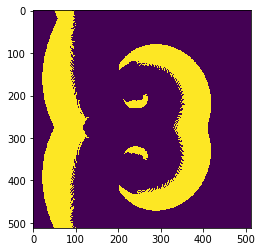

In [1592]:
plt.imshow(inc)

# Highlight activation/deactivation fronts

Note that the values of the thresholds for detecting activation/deactivation fronts might effect the apparent interaction distance of spiral tips.  We must test this dependency, which means I will eventually need to make threshold selection interactive.

NEXT steps: (with the act/deact. fronts plotted as closed strings) measure the smoothed arc length of the pseudo-front connecting two entangled spiral tips.  Does their entanglement make predictions about their relative statistics? Perhaps another metric to consider could be the area of increasing Vmem. 

In [1593]:
# #for this section to run, we need inc and dec to be relu filters
# # #interest in these thresholds come from their frequency, slope in frequency, or 'Vmem_versus_time_sampled_from_center.png'
# # #note that these thresholds may be chosen independently, since we explicitely separated image into inc and dec
# fig, (ax1, ax2) = plt.subplots(1,2, frameon=True)
# fig.set_size_inches(14, 6)
# sns.kdeplot(inc.flatten()[inc.flatten()>0], ax=ax1, shade=True)

# #plotting three thresholds of interest for the activation front
# plt.sca(ax1)

# # plt.axvline(0.05, c='Black')#might avoid false fronts
# # plt.axvline(0.5, c='Orange')#middle of jump
# plt.axvline(0.3, c='Red')
# plt.xlabel('Vmem')
# plt.ylabel('freq.')

# #plotting three thresholds of interest for the deactivation front
# # plt.sca(ax2)
# sns.kdeplot(dec.flatten()[dec.flatten()>0], ax=ax2, shade=True)
# # plt.axvline(0.0039, c='Black')#mode
# # plt.axvline(0.2, c='Orange')#min frequency
# plt.axvline(0.3, c='Red')
# plt.xlabel('Vmem')
# plt.ylabel('freq.')

# #format plot
# ax1.annotate(s='increasing', xy=(0.75,0.95), fontsize=16, alpha=0.3, xycoords = 'axes fraction')
# ax2.annotate(s='decreasing', xy=(0.735,0.95), fontsize=16, alpha=0.3, xycoords = 'axes fraction')
# plt.show()
# # plt.savefig('../fig/threshold_selection_sample.png', dpi=300, bbox_inches = 'tight', pad_inches=0)

# #lines cross everywhere:
# # Horrible: 
# # ithresh = 0.05
# # dthresh = 0.0039
# #
# # ithresh = 0.5
# # dthresh = 0.3
# # lines cross at the wrong place: 
# # ithresh = 0.73
# # dthresh = 0.08
# #before doing the following, get spiral tip detection script to be fast enough to get "enough" data overnight.
# #TODO: (eventually for webapp): make a widget pop up and use this plot interactively to select the desired activation/deactivation fronts
# #  then, TODO: include a second popup that shows you the current activation/deactivation fronts
# plt.imshow(sk.filters.gaussian(inc, sigma=10, mode='wrap'), cmap='gray')

In [1594]:
#these thresholds give good lines that don't cross uniquely, but they might if we consider erosions
dthresh = 0.3
ithresh = 0.3

contours_raw = measure.find_contours(image, level=ithresh, fully_connected='low', positive_orientation='low')
contours_edge = measure.find_contours(inc, 0.5)
# contours_edge = measure.find_contours(sk.filters.gaussian(inc, sigma=1, mode='wrap'), 0.5)
# contours_edge= measure.find_contours(edge, level=.5, fully_connected='low', positive_orientation='low')
# ?sk.filters.gaussian
# mode : {'reflect', 'constant', 'nearest', 'mirror', 'wrap'}, optional

In [1595]:
#put contour sample points into a dataframe
df = pd.concat([pd.DataFrame(c, columns = ['y', 'x']) for c in contours_raw], axis=0)
df = df.reset_index(drop=True)
#color each pixel as increasing (1) or nonincreasing (0)
#rounding to nearest pixel  #lookup pixel on inc
lst = []
for i in range(len(df)):
    x = int(np.around(df.x.iloc[i]))
    y = int(np.around(df.y.iloc[i]))
    lst.append([i, inc[y,x]])
#return indices where 0 maps to 1 or 1 maps to 0
ids = np.argwhere(np.abs(np.diff(np.array(lst)[:,1]))==1).flatten()

In [1596]:
#get displacements with pbc with previous step
df['tmp'] = (df.x.shift(-1) - df.x)
df.loc[df.tmp<-500, 'dx']        = df['tmp']+512
df.loc[df.tmp>500, 'dx']         = df['tmp']-512
df.loc[(500>=df.tmp) | (df.tmp>=-500), 'dx']  = df['tmp']
df = df.drop(columns=['tmp'])

df['tmp'] = (df.y.shift(-1) - df.y)
df.loc[df.tmp<-500, 'dy']        = df['tmp']+512
df.loc[df.tmp>500, 'dy']         = df['tmp']-512
df.loc[(500>=df.tmp) | (df.tmp>=-500), 'dy']  = df['tmp']
df = df.drop(columns=['tmp'])

#get distances to next neighbor
df['ds_prev'] = np.sqrt(df.dx**2 + df.dy**2)

#get displacements with pbc next step
df['tmp'] = (df.x.shift(1) - df.x)
df.loc[df.tmp<-500, 'dx']        = df['tmp']+512
df.loc[df.tmp>500, 'dx']         = df['tmp']-512
df.loc[(500>=df.tmp) | (df.tmp>=-500), 'dx']  = df['tmp']
df = df.drop(columns=['tmp'])

df['tmp'] = (df.y.shift(1) - df.y)
df.loc[df.tmp<-500, 'dy']        = df['tmp']+512
df.loc[df.tmp>500, 'dy']         = df['tmp']-512
df.loc[(500>=df.tmp) | (df.tmp>=-500), 'dy']  = df['tmp']
df = df.drop(columns=['tmp'])

#get distances to next neighbor
df['ds'] = np.sqrt(df.dx**2 + df.dy**2)

In [1597]:
print(x_values)
print(y_values)

[206.5 257.5 220.5 219.5 258.5 205.5]
[419.5 343.5 332.5 218.5 208.5 134.5]


In [1598]:
#return positions for those nearest two pixels
#also check that the distance between these two adjacent points are not bigger than np.sqrt(2) pixels (same contour condition)
tips = df.iloc[ids].query('ds<5 and ds_prev<5').copy()

# #DONE: check rough points have the y-axises agree by plotting both here and with the contours
# plt.scatter(y=tips.x, x=tips.y)
# plt.scatter(x=x_values, y=y_values)
# plt.show()

In [1599]:
def interp(x_values, y_values):
    """linear interpolation for y = a*x + b.  returns a,b"""
    xbar = x_values.mean()
    ybar = y_values.mean()
    SSxy = np.dot(x_values,y_values) - x_values.size*xbar*ybar
    SSxx = np.dot(x_values,x_values) - x_values.size*xbar**2
    a = SSxy/SSxx
    b = ybar - a*xbar
    return a,b

def intersect(a1, b1, a2, b2):
    """finds the intersection of two lines"""
    x = (b1 - b2)/(a2 - a1)
    y = a1*x + b1
    return x,y

In [1600]:
# #for a given example rough tip
# tip    = tips.iloc[1]
# #return the three or six contour points closest to the change in inc
# xy12   = df.iloc[tip.name-1:tip.name+2][['x','y']].values
# #get a least squares fit for those values
# a1, b1 = interp(xy12[:,0], xy12[:,1])
# #later: calculate ds for all 
# #return the three or six contour points of in closest to the change in inc
# xy34   = ef.sort_values('ds').head(6).sort_index()[['x','y']].values
# #replace inc line with a least squares fit to the six nearest values
# a2, b2 = interp(xy34[:,0], xy34[:,1])
# intersect(a1, b1, a2, b2)

0.11 seconds elapsed linearly interpolating spiral tips.


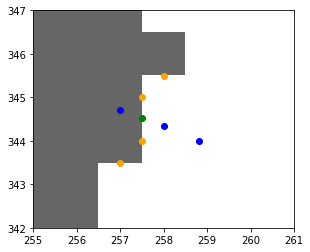

In [1601]:
#linear interpolation of those pixels is too dependent on the smoothing parameters (i.e. the gaussian filter)
#Ythis can be used to get smoother results.  In order to get results robust to parameter choice, we simply average the two nearest pixels
#put contour sample points into a dataframe for the boundary of the increasing regiob
ef = pd.concat([pd.DataFrame(c, columns = ['y', 'x']) for c in contours_edge], axis=0)
ef = ef.reset_index(drop=True)
start = time.time()
lst = []
for i in range(len(tips)):
    
    #for the ith tip
    tip    = tips.iloc[i]
    
    #get ds = distances from current pixel with pbc
    tip = tips.iloc[i]
    ef['tmp'] = (ef.x - tip.x)
    ef.loc[ef.tmp<-500, 'dx']        = ef['tmp']+512
    ef.loc[ef.tmp>500, 'dx']         = ef['tmp']-512
    ef.loc[(500>=ef.tmp) | (ef.tmp>=-500), 'dx']  = ef['tmp']
    ef = ef.drop(columns=['tmp'])
    ef['tmp'] = (ef.y - tip.y)
    ef.loc[ef.tmp<-500, 'dy']        = ef['tmp']+512
    ef.loc[ef.tmp>500, 'dy']         = ef['tmp']-512
    ef.loc[(500>=ef.tmp) | (ef.tmp>=-500), 'dy']  = ef['tmp']
    ef = ef.drop(columns=['tmp'])
    #get distances to tip
    ef['ds'] = np.sqrt(ef.dx**2 + ef.dy**2)
    
    try:
        #return the three or six contour points closest to the change in inc
        xy12   = df.iloc[tip.name-1:tip.name+2][['x','y']].values
        #get a least squares fit for those values
        a1, b1 = interp(xy12[:,1], xy12[:,0])
        #return the three or six contour points of in closest to the change in inc
        xy34   = ef.sort_values('ds').head(4).sort_index()[['x','y']].values
        #replace inc line with a least squares fit to the six nearest values
        a2, b2 = interp(xy34[:,1], xy34[:,0])

        #return the two closest members and use linear interpolation for subpixel accuracy
        y5,x5 = intersect(a1, b1, a2, b2)
        lst.append([x5,y5])
    except (RuntimeError, TypeError, NameError):
        print("Tell Tim to update linear interpolation of spiral tips with xy-->yx exception handling.")
        #TODO: if errors are thrown for dividing by zero, repeat linear interpolation with xy-->yx
        #TODO: if both of ^those yield an error, then plot and check for a perfect cross.  
        #      ff that cross exists, average the isoline contour values used
#return linearly interpolated spiral tips
lst = np.array(lst)
xtips = lst[:,0]
ytips = lst[:,1]
end = time.time()
print('%s seconds elapsed linearly interpolating spiral tips.' % str(np.around(end-start,2)))

plt.scatter(x=xy12[:,0], y=xy12[:,1], c='blue')
plt.scatter(x=xy34[:,0], y=xy34[:,1], c='orange')
plt.scatter(x=lst[-1,0], y=lst[-1,1], c='green')

a,b,c,d = np.around(plt.gca().axis())
plt.imshow(inc,zorder=0, alpha=.6, cmap='gray')
plt.axis([a-2,b+2,c-1,d+1])
# plt.imshow(inc[int(a):int(b),int(c):int(d)],zorder=0, alpha=1, cmap='gray')
del a,b,c,d

plt.show()
# plt.savefig('marching_squares_fast_smoothing_example.png')

In [1563]:
#[deprecated] activation deactivation front scratchwork
#use marching squares algorithm to detect contours of constant value
# contoursA_raw = measure.find_contours(inc, level=ithresh, fully_connected='low', positive_orientation='low')
# contoursD_raw = measure.find_contours(dec, level=dthresh, fully_connected='low', positive_orientation='low')

# #select activation contours if they are 'on threshold'
# # maxsample = 10
# m_values = []
# # for each contour
# pos = 0
# for n, contour in enumerate(contoursA_raw):
#     m = len(contour[:])#TODO: np.min(maxsample, len(contour[:]))
#     #TODO: sample a max sample of maxsample
#     #     samp = np.arange(len(contour)) == np.int(np.around(np.random.shuffle(contour)[:m]))
#     #     pts = contour[samp] 
#     samp = contour[:]
#     #sample m Vmem's and average them
#     lst = []
#     for x,y in np.around(contour):
#         lst.append(image[int(x), 512-int(y)])
#     #if ^that average is close enough to ithresh/dthresh, then keep contour
#     if np.mean(lst) < (ithresh + 0.15):
#         m_values.append(pos)
#     pos += 1
# # convert m_values to a boolean array
# lst = [(lambda y:False)(x) for x in list(range(len(contoursA_raw)))]
# for m in m_values:
#     lst[m] = True
# contoursA = [contoursA_raw[m] for m in m_values]

# #select activation contours if they are 'on threshold'
# # maxsample = 10
# m_values = []
# # for each contour
# pos = 0
# for n, contour in enumerate(contoursD_raw):
#     m = len(contour[:])#TODO: np.min(maxsample, len(contour[:]))
#     #TODO: sample a max sample of maxsample
#     #     samp = np.arange(len(contour)) == np.int(np.around(np.random.shuffle(contour)[:m]))
#     #     pts = contour[samp] 
#     samp = contour[:]
#     # sample m Vmem's and average them
#     lst = []
#     for x,y in np.around(contour):
#         lst.append(image[int(x), 511-int(y)])#second one
#     # if ^that avg is close to ithresh/dthresh, then keep contour
#     if np.mean(lst) < (dthresh + 0.15):
#         m_values.append(pos)
#     pos += 1
# # convert m_values to a boolean array
# lst = [(lambda y:False)(x) for x in list(range(len(contoursD_raw)))]
# for m in m_values:
#     lst[m] = True
# contoursD = [contoursD_raw[m] for m in m_values]

In [1564]:
# #return activation/deactivation fronts if they are 'on threshold'
# #filter out points from each contour that is not near threshold
# filt = lambda xy: np.isclose(image[int(xy[0]), int(xy[1])], ithresh, atol=1e-01)
# contoursA = []
# for contour in contoursA_raw[:1]:
#     lst = np.array([xy for xy in contour if filt(np.around(xy))])
# #     lst = np.array([filt(np.around(xy)) for xy in contour])
#     if lst.shape[0]>0:
#         #remove last element since these curves need not be closed for current applications
#         contoursA.append(lst[5:-5])

# #repeat for deactivation fronts
# filt = lambda xy: np.isclose(image[int(xy[0]), int(xy[1])],dthresh,atol=1e-01)
# contoursD = []
# for contour in contoursD_raw:
#     lst = np.array([xy for xy in contour if filt(np.around(xy))])
#     if lst.shape[0]>0:
#         #remove last element since these curves need not be closed for current applications
#         contoursD.append(lst[5:-5])
        
# deprecatedTODO: return a largest connected subset of a contour that is 'on threshold'.  Input type: np.array
#DONE: return a boolean index array of on threshold positions

#637 is a false spiral tip. it's a jump between contours.  
#This is fixed by the df filter.  But ds seems to be having trouble.  
#Check the calculation of ds! Ah ha! I need to check df before AND after every pixel
# df.iloc[635:640]

In [1565]:
#filter out contour points if they are large
# f = np.vectorize(lambda x: x if x>ithresh else 0.)
# inc = ifilter(image)
# ?sk.filters.scharr

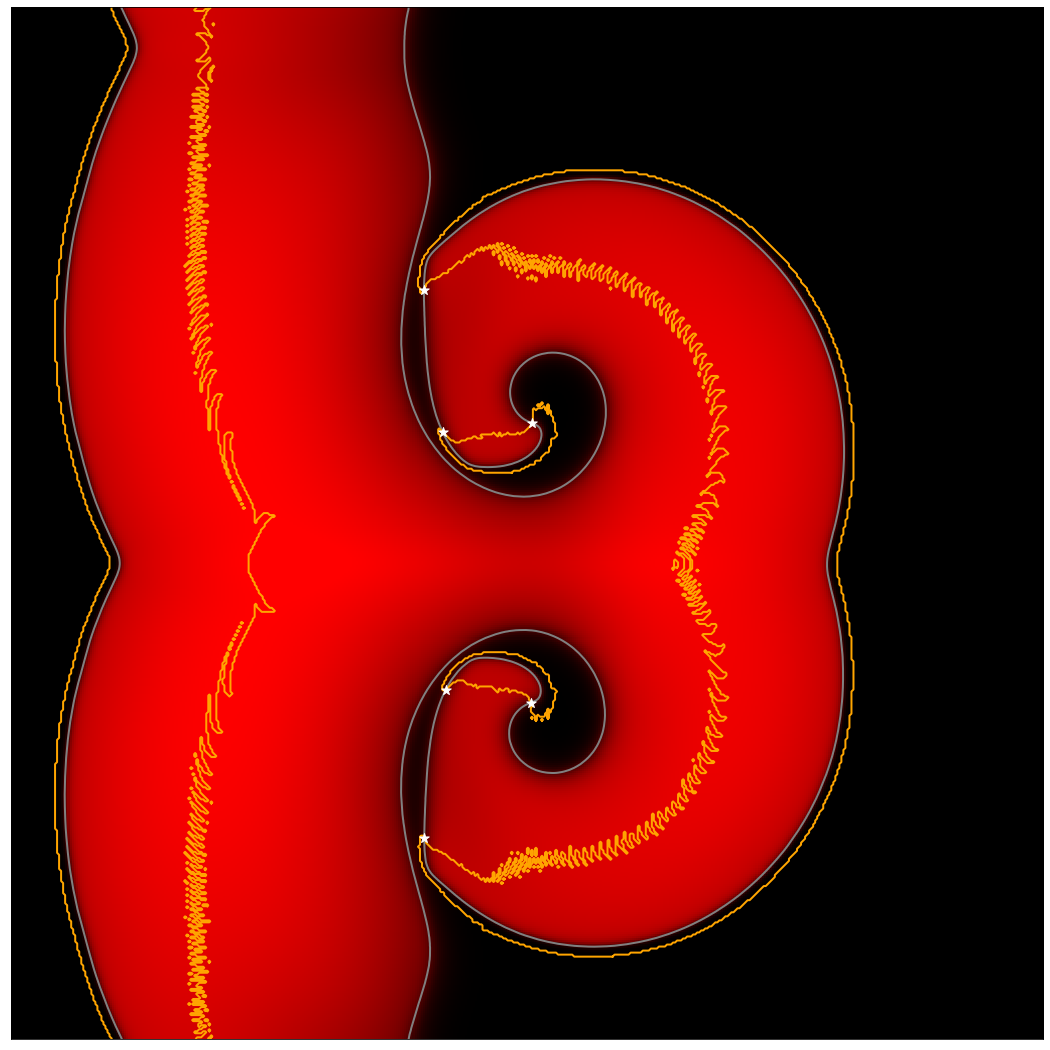

In [1602]:
# Display the image and plot all contours found
# fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
fig, ax = plt.subplots()
ax.imshow(img, cmap=plt.cm.gray)
# edge  = sk.filters.scharr(dec)
# ax.imshow(edge, cmap='gray')
ax.scatter(y=ytips, x=xtips, s=100, marker = '*', c='white', zorder = 10)

for n, contour in enumerate(contours_raw):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, c='gray')
for n, contour in enumerate(contours_edge):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, c='orange')
# for n, contourA in enumerate(contoursA_raw):
#     ax.plot(contourA[:, 1], contourA[:, 0], linewidth=1, c='blue')
# for n, contourD in enumerate(contoursD_raw):
#     ax.plot(contourD[:, 1], contourD[:, 0], linewidth=1, c='yellow')

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])

# fig = plt.gcf()
fig.set_size_inches(18.5, 20.5)
# plt.title('ithresh = '+str(ithresh)+', dthresh = '+str(dthresh), fontsize=30)
# 
# plt.show()
plt.savefig('../fig/Vmem_tips_linear_smoothing.png', dpi=300, bbox_inches = 'tight', pad_inches=0)
# plt.savefig('../fig/Vmem_tips_no_smoothing.png', dpi=300, bbox_inches = 'tight', pad_inches=0)
# plt.savefig('../fig/grayscale_tips_no_smoothing.png', dpi=300, bbox_inches = 'tight', pad_inches=0)

In [1255]:
#howdo
#contoursA[i] gives the ith contour
#contourA[:, 0 or 1] gives a list of all of the x or y coords for some contour

#tests
# for n, contourA in enumerate(contoursA):
#     print(str(n) + ' is n.  shape of contour is '+str(contourA.shape))

In [1233]:
#LAME import EDA which has expvar and expvars
# from pyeda.inter import *

In [1555]:
#DONE: after ^those, find spiral tips where those closer than pxlthrsh, where pxlthrsh is as small as it can be to robustly detect the pixels
# NB: this is a computational lower bound on apparent tip interaction distance
#DONE: convert m_values to a boolean array
#DONE: plot ^those curves thicker in the above figure


In [1173]:
#scratch work history for making faster invcmp
# from matplotlib.backends.backend_agg import FigureCanvasAgg
# fig = Figure(figsize=(5, 4), dpi=100)
# # A canvas must be manually attached to the figure 
# canvas = FigureCanvasAgg(fig)
# # your plotting here
# canvas.draw()
# s, (width, height) = canvas.print_to_buffer()
# #Convert to a NumPy array.
# X = np.frombuffer(s, np.uint8).reshape((height, width, 4))
# fig = Figure()
# canvas = FigureCanvas(fig)
# ax = fig.gca()
# ax.text(0.0,0.0,"Test", fontsize=45)
# ax.axis('off')
# canvas.draw()       # draw the canvas, cache the renderer
# image = np.frombuffer(canvas.buffer_rgba(), dtype='uint8')

## scratchwork for find intersecting points on curves

In [1738]:
#TODO: for each contour
A = contours_raw[0]
B = contours_edge[2]

#get spline interpolations
k = 3 #order of spline interpolation
t_values = np.linspace(0,1,num=A.shape[0])
splA = BSpline(t_values, A, k)
t_values = np.linspace(0,1,num=B.shape[0])
splB = BSpline(t_values, B, k)

In [1631]:
#quickly check if there exist points on those curves that come closer than atol
atol=10
t_values = np.linspace(0,1,50)
s_values = t_values


In [1632]:
nrmlst = [np.linalg.norm(splB(t)-splA(s)) for t in t_values for s in s_values]
crdlst = [(t,s) for t in t_values for s in s_values]

In [1633]:
crdlst[np.argmin(nrmlst)]
nrmlst[np.argmin(nrmlst)]#<atol

1.6449092155395562

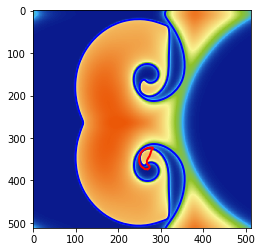

In [1739]:
fig, ax = plt.subplots()
ax.imshow(img)#, cmap=plt.cm.gray)
# edge  = sk.filters.scharr(dec)
# ax.imshow(edge, cmap='gray')

ax.plot(A[:, 1], A[:, 0], linewidth=2, c='blue')
ax.plot(B[:, 1], B[:, 0], linewidth=2, c='red')

In [1637]:
#find local minima if a value smaller than atol exists
np.array(nrmlst)<4

array([False, False, False, ..., False, False, False])

In [1913]:
#iterate through activation/deactivation curve
#whenever the increasing mask goes from 0 to 1 (or 1 to 0), ssave that rough spiral tip

# A = np.vstack(contours_raw)
# B = np.vstack(contours_edge)

A = np.vstack(contoursA_raw)
B = np.vstack(contoursD_raw)

x = 317.5
y = 484.5
#NOTE: y might need to flip to 512-y
atol = 20
Anear = A[(np.isclose(A[:,1], x, atol=atol) & np.isclose(A[:,0], y, atol=atol))]
Bnear = B[(np.isclose(B[:,1], x, atol=atol) & np.isclose(B[:,0], y, atol=atol))]

In [1914]:
# #refine spiral tips

# #for each spiral tip, return a few contour points before and after
# for (x,y) in zip(x_values, y_values):
#     print(x, y)
#     np.close

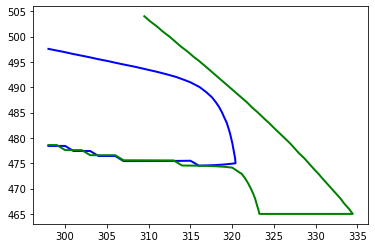

In [1915]:
#plot those contour points near a previously found spiral tip
fig, ax = plt.subplots()
# ax.imshow(img)#, cmap=plt.cm.gray)
# edge  = sk.filters.scharr(dec)
# ax.imshow(edge, cmap='gray')
# ax.axis([x-60,x+60, y-60,y+60])
ax.plot(Anear[:, 1], Anear[:, 0], linewidth=2, c='blue')
ax.plot(Bnear[:, 1], Bnear[:, 0], linewidth=2, c='green')


In [1916]:
#for each value in Anear
#calculate the distance to the nearest value in Bnear
#keep iterating while that distance is above a threshold
#once that distance is below a threshold, keep iterating until the distance starts decreasing
#once that value starts increasing, use newton's method until the closest four values are found, then use linear algebra

In [1917]:
#get spline interpolations
k = 3 #order of spline interpolation
t_values = np.linspace(0,1,num=Anear.shape[0])
splA = BSpline(t_values, Anear, k)
t_values = np.linspace(0,1,num=Bnear.shape[0])
splB = BSpline(t_values, Bnear, k)



In [1918]:
t_values = np.linspace(0,1,50)
nrmlst = [np.linalg.norm(splB(t)-splA(s)) for t in t_values for s in t_values]
crdlst = [(t,s) for t in t_values for s in s_values]

In [1919]:
crdlst[np.argmin(nrmlst)]
# nrmlst[np.argmin(nrmlst)]

(0.9795918367346939, 0.08163265306122448)

In [1920]:
#iterate through the activation front and calculate the rolling change of angle
#when the change of angle is sharp, record that spiral tip.  You can refine it later

In [1921]:
splA(0.7142857142857142)
splB(0.8163265306122448)

array([474.5305338 , 315.10204082])

In [1922]:
df = pd.DataFrame(A, columns=["y", "x"])
df[['dy', 'dx']] = df.diff()
df['theta'] = np.arctan(df['dy']/df['dx'])
df['dtheta'] = df['theta'].diff().shift(-1)

In [1935]:

df.query('-2 < dtheta < -1.6 or 1.6 < dtheta < 2')[['x','y']]


,x,y
937,320.344444,52.000000
2632,320.400000,475.000000
2724,260.000000,506.004444
2870,201.369231,73.000000
3141,267.516667,361.000000
3149,205.369231,455.000000


Naively, I thing a 'kink' of dtheta = -1.7 cooresponds to a clockwise spiral tip and a 'kink' of dtheta = +1.7 cooresponds to a counterclockwise spiral tip

In [1934]:
x_values

array([317.5, 264.5, 265.5, 263.5, 263.5, 317.5])

In [1938]:
y_values

array([484.5, 362.5, 328.5, 199.5, 166.5,  43.5])

## scratchwork for mapping to Vmem won't work by brute force.  Find a linearly changing colormap in rgb

#TODO: once found, change the default colormap in the webapp to that color
#TODO: (eventually) make webapp robust to user error

#10.29.2019
#TODO: clean up notebook
#TODO: test highlighting without the lengthy invcmap step.  consider grayscale maps
#TODO: if ^that appears robust, streamline and make it a reasonably fast script
#TODO: call ^that script from js


#TODO: computational checks for dicty. dispersal

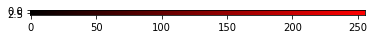

In [966]:
#import known colorbar/voltage mask
# cmap_dir = '../data/colormaps/mat/autumn.png'
# cmap_dir = '../data/colormaps/mat/blue.png'
cmap_dir = '../data/colormaps/mat/red.png'
# cmap_dir = '../data/colormaps/mat/hot.png'#not one to one
# cmap_dir = '../data/colormaps/mat/spring.png'

cmap = sk.io.imread(cmap_dir, as_gray=False)
width= cmap.shape[1]
f = lambda y,x: np.array_equal(y,x)
plt.imshow(cmap)

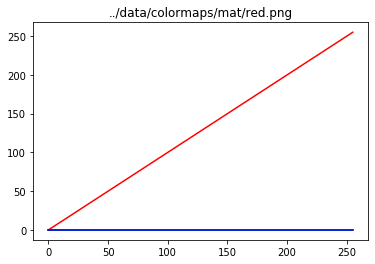

In [967]:
plt.plot(cmap[2,:,0], c='r')
plt.plot(cmap[2,:,1], c='g')
plt.plot(cmap[2,:,2], c='b')
# plt.plot(cmap[1,:,0], c='r')
# plt.plot(cmap[1,:,1], c='g')
# plt.plot(cmap[1,:,2], c='b')
plt.title(cmap_dir)
plt.show()
# x_values = np.arange(0,1,1/256)

In [968]:

# #define scale from colors to Vmem with cmap
# # define np.vectorize(lambda ...) to map rgb data to 
# # cmap[0]-cmap[1]#the first and second dictionaries are for some rbg periodic b.c.'s'
# # search cmap[0] and then cmap[1] for (rounded?) color matches.
# # if one is found assign scalar value for output
# def invcmp(rgb):
#     """map an rgb from cmap to it's scalar value between 0 and 1"""
#     m = np.argwhere([f(rgb,x) for x in cmap[1]])
#     if m.size>0:
#         return m.mean()
#         #         return (m[:,1].mean()/width)
#     else:
#         m = np.argwhere([f(rgb,x) for x in cmap[0]])
#         if m.size>0:
#             return m.mean()
#         else:
#             return np.nan
# invcmp  = np.vectorize(invcmp, otypes=[np.float], signature="(3)->()")

True

## #TODO: change webapp to default to mat/red colormap

# streamline script and time

In [1]:
import time

In [2]:
start = time.time()
import numpy as np
import pandas as pd
import skimage as sk
from skimage import measure

def interp(x_values, y_values):
    """linear interpolation for y = a*x + b.  returns a,b"""
    xbar = x_values.mean()
    ybar = y_values.mean()
    SSxy = np.dot(x_values,y_values) - x_values.size*xbar*ybar
    SSxx = np.dot(x_values,x_values) - x_values.size*xbar**2
    a = SSxy/SSxx
    b = ybar - a*xbar
    return a,b

def intersect(a1, b1, a2, b2):
    """finds the intersection of two lines"""
    x = (b1 - b2)/(a2 - a1)
    y = a1*x + b1
    return x,y
end = time.time()
print('%s seconds elapsed loading packages' % str(np.around(end-start,2)))

1.47 seconds elapsed loading packages


In [3]:
start = time.time()

#ASSUMING the /mat/red cmap is in use
canvas_dir = '../data/redsample000792.png'
canvas_old_dir = '../data/redsample000788.png'
img = sk.io.imread(canvas_dir, as_gray=False)
img_old = sk.io.imread(canvas_old_dir, as_gray=False)

# map an rgb from '/mat/red' cmap to it's scalar value between 0 and 1 by just selecting the red channel"""
image = img[:,:,0]/255
image_old = img_old[:,:,0]/255

#detect whether a pixel is increasing or decreasing.  
ifilter = np.vectorize(lambda x,x_old: 1. if x>x_old else 0.)
inc = ifilter(image,image_old) #mask of increasing cells between a few frames

#get contours by a marching squares algorithm (which can be parallelized to increase performance in theory)
ithresh = 0.3
contours_raw = measure.find_contours(image, level=ithresh, fully_connected='low', positive_orientation='low')
contours_edge = measure.find_contours(inc, 0.5)

#put contour sample points into a dataframe
df = pd.concat([pd.DataFrame(c, columns = ['y', 'x']) for c in contours_raw], axis=0)
df = df.reset_index(drop=True)
#color each pixel as increasing (1) or nonincreasing (0)
#rounding to nearest pixel  #lookup pixel on inc
lst = []
for i in range(len(df)):
    x = int(np.around(df.x.iloc[i]))
    y = int(np.around(df.y.iloc[i]))
    lst.append([i, inc[y,x]])
#return indices where 0 maps to 1 or 1 maps to 0
ids = np.argwhere(np.abs(np.diff(np.array(lst)[:,1]))==1).flatten()

#get displacements with pbc with previous step
df['tmp'] = (df.x.shift(-1) - df.x)
df.loc[df.tmp<-500, 'dx']        = df['tmp']+512
df.loc[df.tmp>500, 'dx']         = df['tmp']-512
df.loc[(500>=df.tmp) | (df.tmp>=-500), 'dx']  = df['tmp']
df = df.drop(columns=['tmp'])
df['tmp'] = (df.y.shift(-1) - df.y)
df.loc[df.tmp<-500, 'dy']        = df['tmp']+512
df.loc[df.tmp>500, 'dy']         = df['tmp']-512
df.loc[(500>=df.tmp) | (df.tmp>=-500), 'dy']  = df['tmp']
df = df.drop(columns=['tmp'])
#get distances to next neighbor
df['ds_prev'] = np.sqrt(df.dx**2 + df.dy**2)

#get displacements with pbc next step
df['tmp'] = (df.x.shift(1) - df.x)
df.loc[df.tmp<-500, 'dx']        = df['tmp']+512
df.loc[df.tmp>500, 'dx']         = df['tmp']-512
df.loc[(500>=df.tmp) | (df.tmp>=-500), 'dx']  = df['tmp']
df = df.drop(columns=['tmp'])
df['tmp'] = (df.y.shift(1) - df.y)
df.loc[df.tmp<-500, 'dy']        = df['tmp']+512
df.loc[df.tmp>500, 'dy']         = df['tmp']-512
df.loc[(500>=df.tmp) | (df.tmp>=-500), 'dy']  = df['tmp']
df = df.drop(columns=['tmp'])
#get distances to next neighbor
df['ds'] = np.sqrt(df.dx**2 + df.dy**2)

#return positions for those nearest two pixels
#also check that the distance between these two adjacent points are not bigger than np.sqrt(2) pixels (same contour condition)
tips = df.iloc[ids].query('ds<5 and ds_prev<5').copy()

#linear interpolation of those pixels is too dependent on the smoothing parameters (i.e. the gaussian filter)
#Ythis can be used to get smoother results.  In order to get results robust to parameter choice, we simply average the two nearest pixels
#put contour sample points into a dataframe for the boundary of the increasing regiob
ef = pd.concat([pd.DataFrame(c, columns = ['y', 'x']) for c in contours_edge], axis=0)
ef = ef.reset_index(drop=True)
lst = []
for i in range(len(tips)):
    #for the ith tip,
    tip    = tips.iloc[i]   
    #get ds = distances from current pixel with pbc
    tip = tips.iloc[i]
    ef['tmp'] = (ef.x - tip.x)
    ef.loc[ef.tmp<-500, 'dx']        = ef['tmp']+512
    ef.loc[ef.tmp>500, 'dx']         = ef['tmp']-512
    ef.loc[(500>=ef.tmp) | (ef.tmp>=-500), 'dx']  = ef['tmp']
    ef = ef.drop(columns=['tmp'])
    ef['tmp'] = (ef.y - tip.y)
    ef.loc[ef.tmp<-500, 'dy']        = ef['tmp']+512
    ef.loc[ef.tmp>500, 'dy']         = ef['tmp']-512
    ef.loc[(500>=ef.tmp) | (ef.tmp>=-500), 'dy']  = ef['tmp']
    ef = ef.drop(columns=['tmp'])
    #get distances to tip
    ef['ds'] = np.sqrt(ef.dx**2 + ef.dy**2)

    try:
        #return the three or six contour points closest to the change in inc
        xy12   = df.iloc[tip.name-1:tip.name+2][['x','y']].values
        #get a least squares fit for those values
        a1, b1 = interp(xy12[:,1], xy12[:,0])
        #return the three or six contour points of in closest to the change in inc
        xy34   = ef.sort_values('ds').head(4).sort_index()[['x','y']].values
        #replace inc line with a least squares fit to the six nearest values
        a2, b2 = interp(xy34[:,1], xy34[:,0])

        #return the two closest members and use linear interpolation for subpixel accuracy
        y5,x5 = intersect(a1, b1, a2, b2)
        lst.append([x5,y5])
    except (RuntimeError, TypeError, NameError):
        print("Tell Tim to update linear interpolation of spiral tips with xy-->yx exception handling.")
        #TODO: if errors are thrown for dividing by zero, repeat linear interpolation with xy-->yx
        #TODO: if both of ^those yield an error, then plot and check for a perfect cross.  
        #      ff that cross exists, average the isoline contour values used

#return linearly interpolated spiral tips
lst = np.array(lst)
xtips = lst[:,0]
ytips = lst[:,1]
end = time.time()
print('%s seconds elapsed detecting peaks for this frame' % str(np.around(end-start,2)))

0.51 seconds elapsed detecting peaks for this frame


In [8]:
xytips = np.vstack([xtips,ytips])
xytips

array([[258.19093847, 213.68664837, 204.44736842, 204.59751773,
        215.27045923, 257.50769207],
       [205.98924432, 210.18664837, 140.05263158, 411.78900709,
        338.03087932, 344.51923017]])

In [16]:
#TODO: (later) dump any preexisting ../tmp/tip_log.csv (put this in an initialization script.py)
#TODO: initialize header of ../tmp/tip_log.csv
#TODO: open log in append mode
# with open('../tmp/tip_log.csv', 'a') as f:
#     ff.to_csv(f, header=True)

#TODO: add an append xytips to file command before returning tip positions
frameno = 791
out_data = dict({'frame':frameno+0*xtips,'x':xtips,'y':ytips})

#TODO: make ^that append statement appear at the end of a callable script that I can import into a separate ipython notebook.

# out_data = np.vstack([frameno+0*xtips,xtips,ytips])

In [19]:
ff = pd.DataFrame(out_data)

In [25]:
with open('../tmp/tip_log.csv', 'a') as f:
    ff.to_csv(f, header=True)

In [26]:
gf = pd.read_csv('../tmp/tip_log.csv', index_col=0)

In [27]:
gf

,791.0,258.19093847354577,205.98924431917035
0,,,
1.0,791.0,213.68664837246848,210.18664837246848
2.0,791.0,204.44736842105954,140.05263157894046
3.0,791.0,204.5975177305063,411.7890070922188
4.0,791.0,215.27045923212242,338.03087932039136
5.0,791.0,257.50769206955647,344.51923017389134
NaN,frame,x,y
0.0,791.0,258.19093847354577,205.98924431917035
1.0,791.0,213.68664837246848,210.18664837246848
2.0,791.0,204.44736842105954,140.05263157894046


In [28]:
?ff.astype

In [ ]:
k